In [10]:
library(tidyverse)
# Helper packages
library(recipes) # for feature engineering
# Modeling packages
library(glmnet) # for implementing regularized regression
library(caret) # for automating the tuning process
# Model interpretability packages
library(vip) # for variable importance

library(rsample)

Warning message:
"package 'rsample' was built under R version 4.0.3"


In [11]:
ames <- read_csv('data/ames.csv')
set.seed(123)
split <- initial_split(ames, prop = 0.7,
strata = "Sale_Price")
ames_train <- training(split)
ames_test <- testing(split)

Parsed with column specification:
cols(
  .default = col_character(),
  Lot_Frontage = col_double(),
  Lot_Area = col_double(),
  Year_Built = col_double(),
  Year_Remod_Add = col_double(),
  Mas_Vnr_Area = col_double(),
  BsmtFin_SF_1 = col_double(),
  BsmtFin_SF_2 = col_double(),
  Bsmt_Unf_SF = col_double(),
  Total_Bsmt_SF = col_double(),
  First_Flr_SF = col_double(),
  Second_Flr_SF = col_double(),
  Low_Qual_Fin_SF = col_double(),
  Gr_Liv_Area = col_double(),
  Bsmt_Full_Bath = col_double(),
  Bsmt_Half_Bath = col_double(),
  Full_Bath = col_double(),
  Half_Bath = col_double(),
  Bedroom_AbvGr = col_double(),
  Kitchen_AbvGr = col_double(),
  TotRms_AbvGrd = col_double()
  # ... with 15 more columns
)

See spec(...) for full column specifications.



In [12]:
# Create training feature matrices
# we use model.matrix(...)[, -1] to discard the intercept
X <- model.matrix(Sale_Price ~ ., ames_train)[, -1]
# transform y with log transformation
Y <- log(ames_train$Sale_Price)

In [14]:
?model.matrix

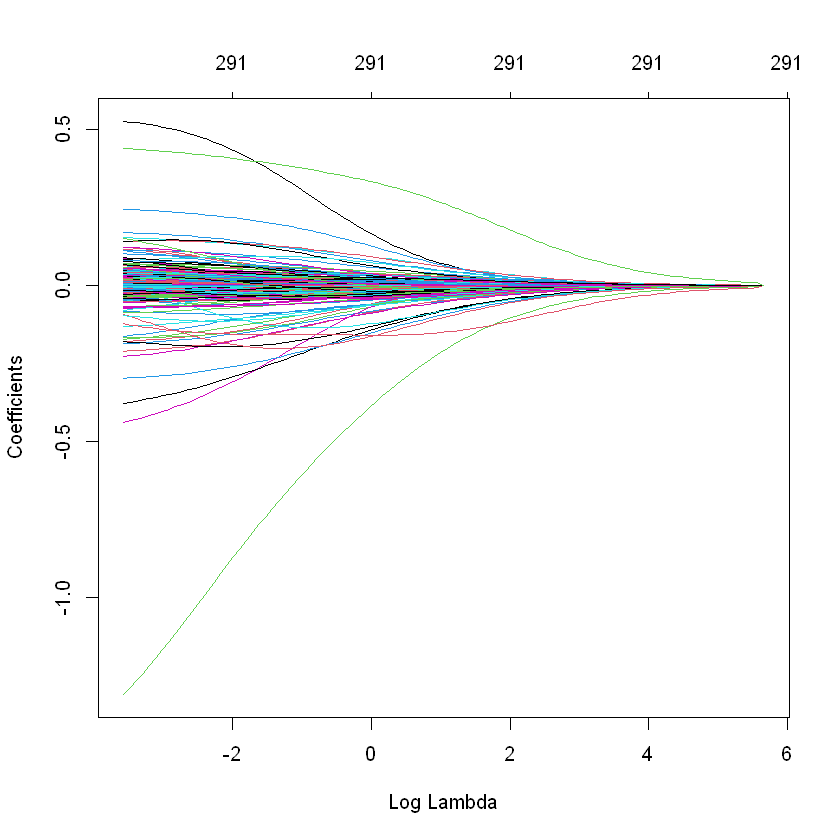

In [15]:
# Apply ridge regression to attrition data
ridge <- glmnet(
x = X,
y = Y,
alpha = 0
)
plot(ridge, xvar = "lambda")

In [17]:
# lambdas applied to penalty parameter
ridge$lambda %>% head()

# small lambda results in large coefficients
coef(ridge)[c("Latitude", 'Overall_QualVery_Excellent'), 100]

# large lambda results in small coefficients
coef(ridge)[c('Latitude', 'Overall_QualVery_Excellent'), 1]

[1] 285.8055 260.4153 237.2807 216.2014 196.9946 179.4942

Latitude Overall_QualVery_Excellent 
                 0.4387682                  0.1420396

Latitude Overall_QualVery_Excellent 
              6.382385e-36               9.838114e-37

Recall that 𝜆 is a tuning parameter that helps to control our model from
over-fitting to the training data. To identify the optimal 𝜆 value we can use
k-fold cross-validation (CV). glmnet::cv.glmnet() can perform k-fold CV, and
by default, performs 10-fold CV. Below we perform a CV glmnet model with
both a ridge and lasso penalty separately:

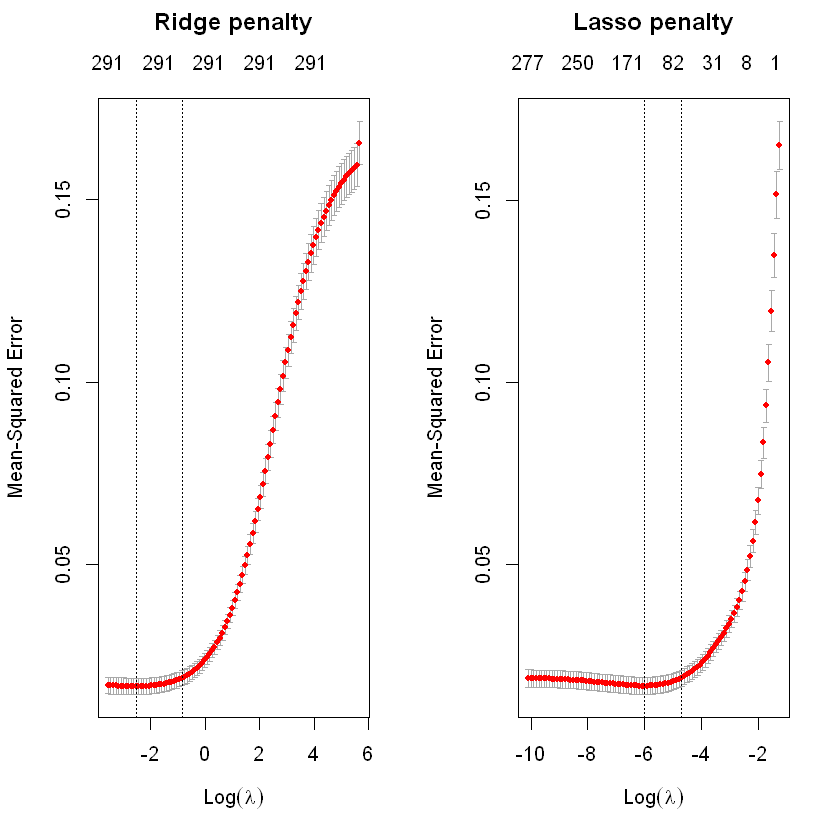

In [19]:
# Apply CV ridge regression to Ames data
ridge <- cv.glmnet(
x = X,
y = Y,
alpha = 0
)
# Apply CV lasso regression to Ames data
lasso <- cv.glmnet(
x = X,
y = Y,
alpha = 1
)
# plot results
par(mfrow = c(1, 2))
plot(ridge, main = 'Ridge penalty\n\n')
plot(lasso, main = 'Lasso penalty\n\n')

In [20]:
# Ridge model
min(ridge$cvm)

ridge$lambda.min


ridge$cvm[ridge$lambda == ridge$lambda.1se]

ridge$lambda.1se # lambda for this MSE



[1] 0.01660433

[1] 0.07952707

[1] 0.01882972

[1] 0.4244121

In [22]:
# Lasso model
min(lasso$cvm)

lasso$lambda.min # lambda for this min MSE

lasso$cvm[lasso$lambda == lasso$lambda.1se] # 1-SE rule

lasso$lambda.1se # lambda for this MSE

[1] 0.0166611

[1] 0.00248579

[1] 0.01884155

[1] 0.00914368

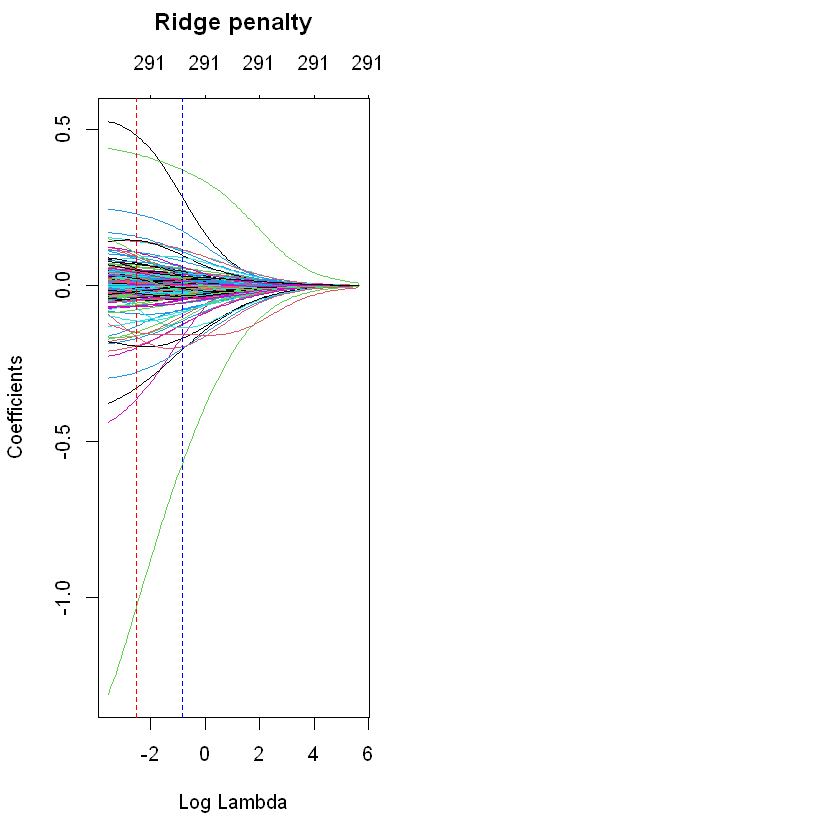

In [24]:
# Ridge model
ridge_min <- glmnet(
x = X,
y = Y,
alpha = 0
)
# Lasso model
lasso_min <- glmnet(
x = X,
y = Y,
alpha = 1
)
par(mfrow = c(1, 2))
# plot ridge model
plot(ridge_min, xvar = 'lambda', main = 'Ridge penalty\n\n')
abline(v = log(ridge$lambda.min), col = 'red', lty = 'dashed')
abline(v = log(ridge$lambda.1se), col = 'blue', lty = 'dashed')

In [25]:
# for reproducibility
set.seed(123)
# grid search across
cv_glmnet <- train(
x = X,
y = Y,
method = 'glmnet',
preProc = c('zv', 'center', 'scale'),
trControl = trainControl(method = 'cv', number = 10),
tuneLength = 10
)

# model with lowest RMSE
cv_glmnet$bestTune

# plot cross-validated RMSE
ggplot(cv_glmnet)